# 11. Time Series Fundamentals

## What we're going to cover

* Downloading and formatting time series data (the historical price of Bitcoin)
* Writing a preprocessing function to prepare our time series data
* Setting up multiple time series modelling experiments
* Building a multivariate model to take in multivariate time series data
* Replicating the N-Beats algorithm using TensorFlow
* Making forecasts with prediction intervals
* Demonstrating why time series forecasting can be BS with the turkey problem

## Time series inputs and outputs

What will the price of Bitcoin be tomorrow? -> Actual Output<br>
[batch_size, window_size] -> [horizon]

## Get Data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we downloaded the data from here: https://www.coindesk.com/price/bitcoin

In [1]:
!curl "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv" --output "Data/Time_Series/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  174k  100  174k    0     0   462k      0 --:--:-- --:--:-- --:--:--  464k


## Importing time series with pandas

In [2]:
import pandas as pd

# Lets read in the Bitcoin data and parse the dates
df = pd.read_csv('Data/Time_Series/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', parse_dates=["Date"], index_col=["Date"])

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


We've collected the historical price of Bitcoin for the past 8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can mean thousands to tens of thousands to millions).

A smaller number of samples is typically what you'll run into with time series data problems.

**Note:** The seasonality of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 265 because we collect one sample per day meaning we'll get 365 samples per year.

## Types of Time Series Data

* Trend: time series has a clear long-term increase or decrease (may or may not be linear)
* Seasonal: time series affected by seasonal factors such as time of year (eg increased sales towards the end of the year) or day of week
* Cyclic: time series shows rises and falls over an unfixed period, these tend to be longer/more variable than seasonal patterns.

In [4]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns = {"Closing Price (USD)": "Price"})
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


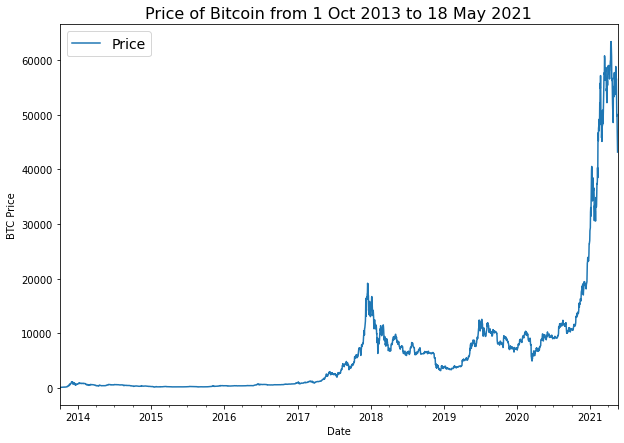

In [5]:
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize = (10, 7));
plt.ylabel("BTC Price");
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize = 16);
plt.legend(fontsize = 14);

In [13]:
import csv
from datetime import datetime

date_list = []
price_list = []
with open('Data/Time_Series/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter= ",")
    next(csv_reader) # skip first line
    for line in csv_reader:
        date_list.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as datetime objects
        price_list.append(float(line[2])) # get the closing price as float

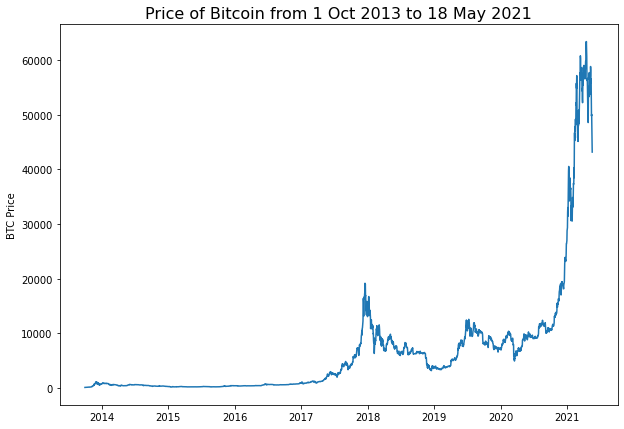

In [15]:
import numpy as np

plt.figure(figsize = (10, 7));
plt.plot(date_list, price_list);
plt.ylabel("BTC Price");
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize = 16);

## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [16]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices.Price.to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [17]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, prices, test_size = 0.2, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

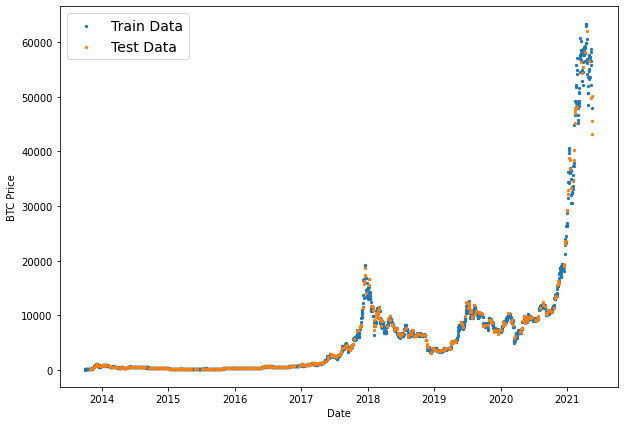

In [18]:
# Lets plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s = 5, label = "Train Data")
plt.scatter(X_test, y_test, s = 5, label = "Test Data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize = 14)
plt.show()

## Create train and test sets for time series (the right way)

In [19]:
# create train and test splits the right way for time series data
split_size = int(0.8 * len(prices))

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

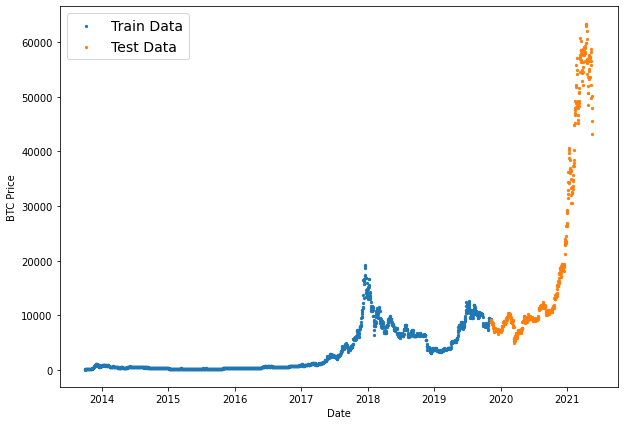

In [20]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s = 5, label = "Train Data")
plt.scatter(X_test, y_test, s = 5, label = "Test Data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize = 14)
plt.show()

In [22]:
### Create a plotting function
def plot_time_series(timesteps, values, format = ".", start = 0, end = None, label = None):
    """
    Plots timesteps (a series of points in time) against values (a series of values across timesteps)
    Parameters
    ---------
    timesteps : array of timesteps values
    values : array of values across time
    format : style of plot, default '.'
    start : where to start the plot (setting a value will index from start of timesteps)
    end : where to end the plot (similar to start but for the end)
    label : label to show on plot about values, default None
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label = label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)

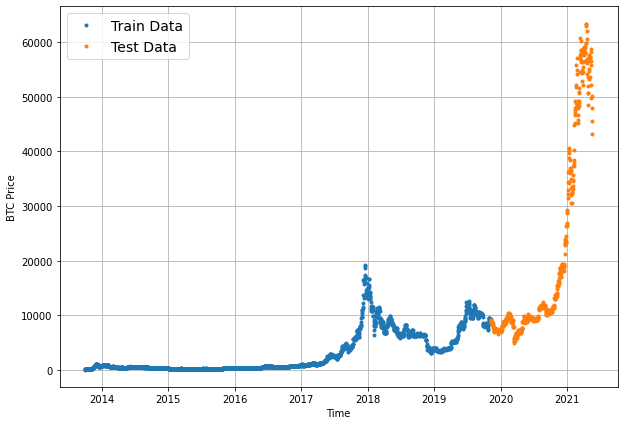

In [23]:
plt.figure(figsize = (10, 7))
plot_time_series(timesteps=X_train, values = y_train, label = "Train Data")
plot_time_series(timesteps=X_test, values = y_test, label = "Test Data")

## Modelling Experiments

* **Horizon** : number of timesteps into the future we're going to predict
* **Window size** : number of timesteps we're going to use to predict **horizon**

|Experiment|Model|horizon|window|
|----------|-----|-------|------|
|0|Naive model (baseline)|||
|1|Dense model|1|7|
|2|Same as model 1|1|30|
|3|Same as model 1|7|30|
|4|Conv1D|1|7|
|5|LSTM|1|7|
|6|Same as model 1 (but with multivariate data|1|7|
|7|N-BEATS algorithm|1|7|
|8|Ensemble (multiple models stacked together|1|7|
|9|Future Prediction model|1|7|
|10|Same as model 1 (but with turkey data introduced|1|7|